### Calibrate the camera

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

def calibrate_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [2]:
def undistort_image(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [510]:
def sobel(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [513]:
def sobel_l(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [30]:
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [577]:
def gray_thresh(img, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    binary_output = np.zeros_like(gray)
    binary_output[(gray >= thresh[0]) & (gray <= thresh[1])] = 1
    
    return binary_output

In [500]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [92]:
def s_channel(img, thresh=(170, 255)):
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Threshold color channel
    binary = np.zeros_like(s_channel)
    binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary

In [3]:
def create_binary_image(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel 
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combine results
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

In [699]:
def camera_to_bird_eye_transform(img):
    offset_x = 290
    offset_y = 0
    height, width = 720, 1280
    #src = np.float32([[593, 450], [688, 450], [193, height], [1116, height]])
    src = np.float32([[585, 455], [698, 455], [188, height], [1123, height]])
    dst = np.float32([[offset_x,offset_y], [width - offset_x, offset_y], [offset_x, height - offset_y], [width - offset_x, height - offset_y]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (width, height))
    
    xm_per_pix = 3.7/(width - 2 * offset_x) # meters per pixel in x dimension
    ym_per_pix = 30/(height - 2 * offset_y) # meters per pixel in y dimension
    
    return warped, M, xm_per_pix, ym_per_pix

In [5]:
def find_fit_polynomials(binary_warped, xm_per_pix, ym_per_pix):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit, right_fit, left_fit_cr, right_fit_cr)

In [6]:
def generate_plotting_data(binary_warped, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx

In [7]:
def calculate_curvature(ploty, left_fit_cr, right_fit_cr, xm_per_pix, ym_per_pix):
    y_eval = np.max(ploty)
    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

In [8]:
def calculate_offset(left_fitx, right_fitx, width, height, xm_per_pix):
    left = left_fitx[height - 1]
    right = right_fitx[height - 1]
    car_center = left + ((right - left) / 2)
    offset = (width / 2) - car_center
    return offset * xm_per_pix

In [9]:
def project_lane(img, warped, M, ploty, left_fitx, right_fitx):
    Minv = np.linalg.inv(M)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

In [10]:
def render_text(img, left_curverad, right_curverad, offset):
    left_text = "Left curvature  = {0:5.0f} m".format(left_curverad)
    right_text = "Right curvature = {0:5.0f} m".format(right_curverad)
    offset_text = "Offset = {0:6.2f} cm".format(offset * 100)
    
    result = cv2.putText(img, left_text, (0,40), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0xFF, 0xFF, 0xFF), thickness = 2)
    result = cv2.putText(result, right_text, (0,80), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0xFF, 0xFF, 0xFF), thickness = 2)
    result = cv2.putText(result, offset_text, (0,120), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0xFF, 0xFF, 0xFF), thickness = 2)
    
    return result

### Process image

In [709]:
def process_image(img, mtx, dist):
    undist = undistort_image(img, mtx, dist)
    #binary = create_binary_image(undist, s_thresh=(170, 250), sx_thresh=(32, 128))
    
    
    #binary_s = s_channel(undist, thresh=(170, 250))
    binary_dir = dir_threshold(img, sobel_kernel=5, thresh=(0.7, 1.3))
    binary_x = sobel(undist, orient='x', sobel_kernel=9, thresh=(20, 80))
    #binary_y = sobel(undist, orient='y', sobel_kernel=9, thresh=(20, 80))
    binary_x_l = sobel_l(undist, orient='x', sobel_kernel=9, thresh=(20, 80))
    #binary_mag = mag_thresh(undist, sobel_kernel=3, thresh=(20, 80))
    
    binary_gray = gray_thresh(undist, thresh=(180, 255))
    
    #binary = binary_x
    
    binary = np.zeros_like(binary_x)
    #binary[((binary_x == 1) & (binary_s == 1))] = 1
    #binary[ ((binary_x == 1) & (binary_x_l == 1))] = 1 # ok for shadows
    
    #binary[((binary_x == 1) & (binary_gray == 1))] = 1 
    
    binary[((binary_x == 1) & (binary_x_l == 1)) | ((binary_dir == 1) & (binary_gray == 1))] = 1
    
    #binary[((binary_dir == 1) & (binary_gray == 1))] = 1 # ok for the inital part (party parrot)
    
    warped, M, xm_per_pix, ym_per_pix = camera_to_bird_eye_transform(binary)
    left_fit, right_fit, left_fit_cr, right_fit_cr = find_fit_polynomials(warped, xm_per_pix, ym_per_pix)
    ploty, left_fitx, right_fitx = generate_plotting_data(warped, left_fit, right_fit)

    left_curverad, right_curverad = calculate_curvature(ploty, left_fit_cr, right_fit_cr, xm_per_pix, ym_per_pix)
    #print(left_curverad, 'm', right_curverad, 'm')
    
    height, width, c = img.shape
    offset = calculate_offset(left_fitx, right_fitx, width, height, xm_per_pix)
    #print('Offset {0:.2f} cm'.format(offset * 100))
    
    result = project_lane(undist, warped, M, ploty, left_fitx, right_fitx)
    
    result = render_text(result, left_curverad, right_curverad, offset)
    
    return result

In [12]:
def load_test_images():
    images = []
    
    test_images = glob.glob('test_images/*.jpg')
    
    for idx, fname in enumerate(test_images):
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        images.append(img)
    
    return images

In [628]:
def load_test_frames():
    images = []
    
    test_images = glob.glob('frames/*.jpg')
    
    interesting = [3, 10, 11, 15, 39, 49]
    
    for idx, fname in enumerate(test_images):
        if idx in interesting:
            img = cv2.imread(fname)
            images.append(img)
    
    return images

In [629]:
def load_problematic_frames():
    
    test_images = glob.glob('problematic/*.jpg')
    
    for idx, fname in enumerate(test_images):
        img = cv2.imread(fname)
        images.append(img)
    
    return images

In [13]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera()

In [328]:
images = load_test_images()

In [672]:
images = load_test_frames()

In [673]:
images = load_problematic_frames()

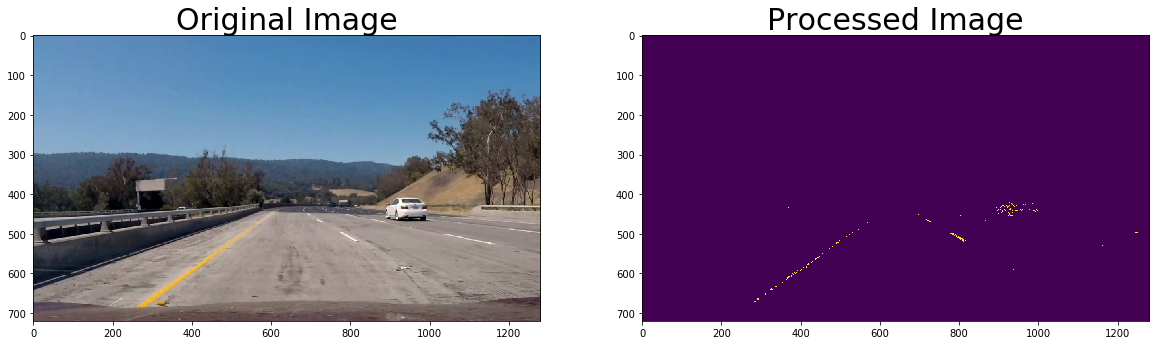

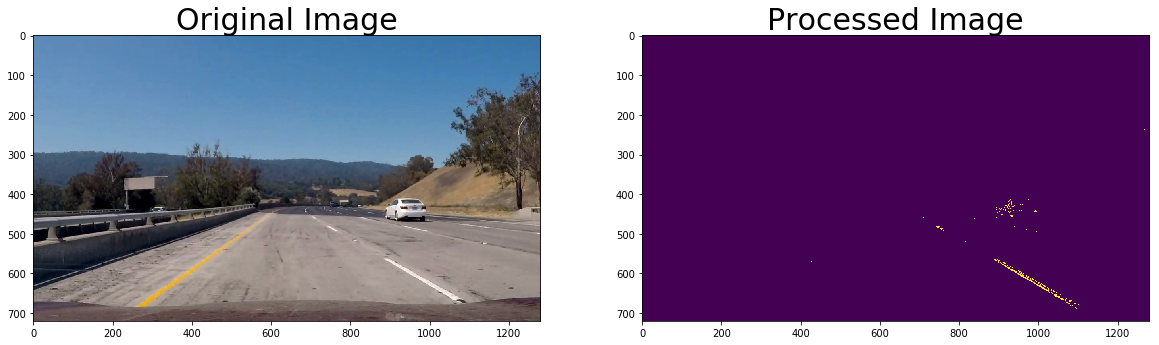

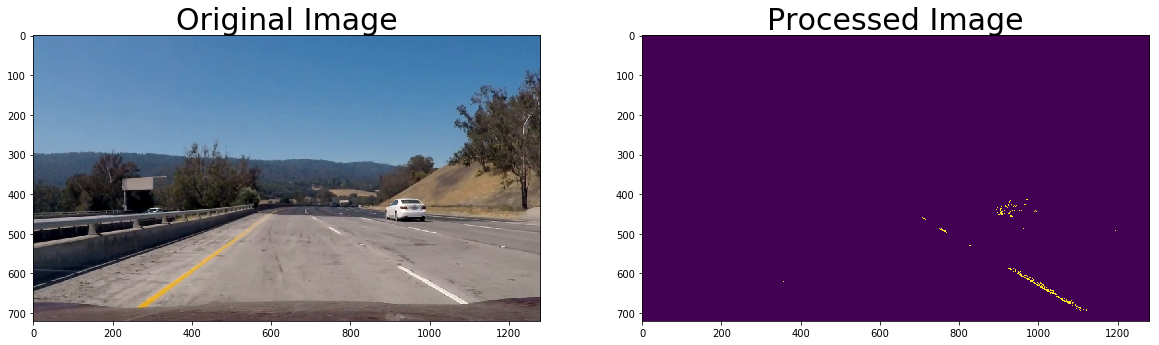

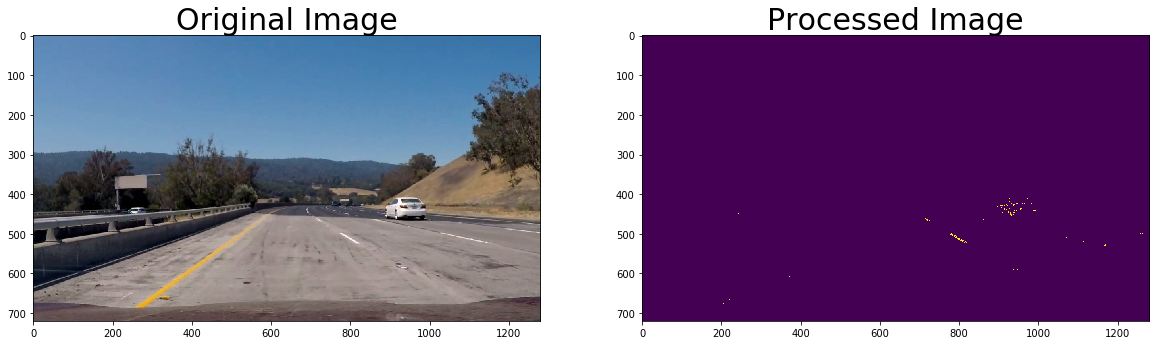

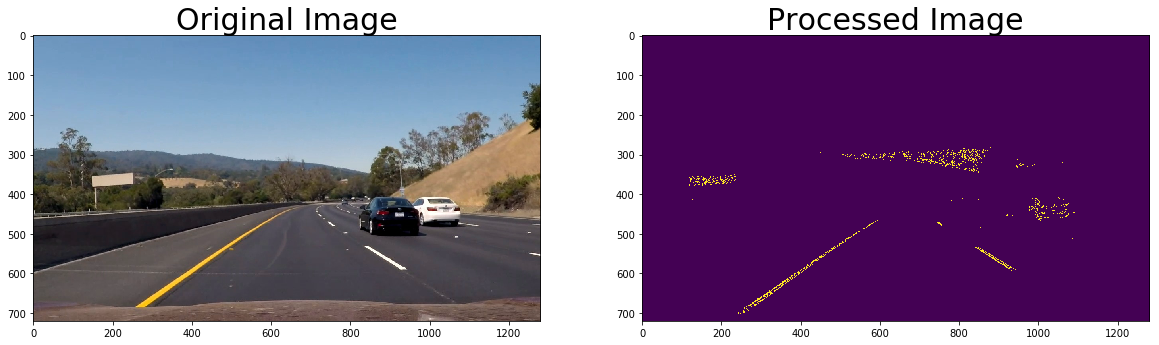

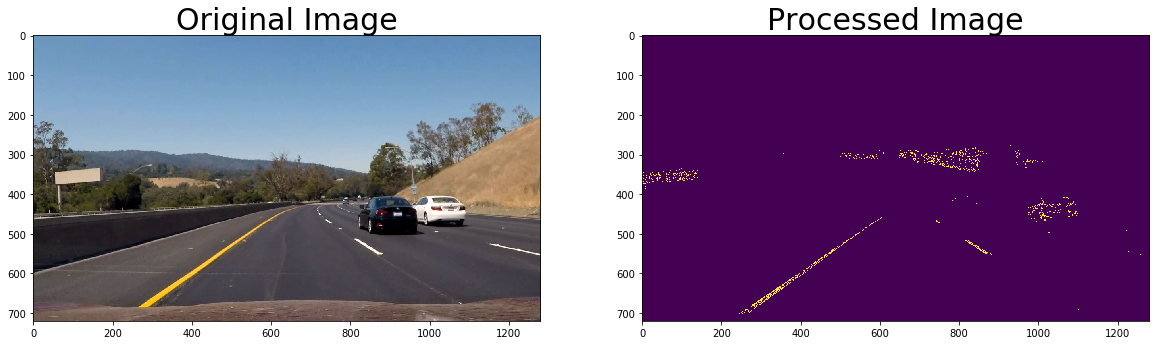

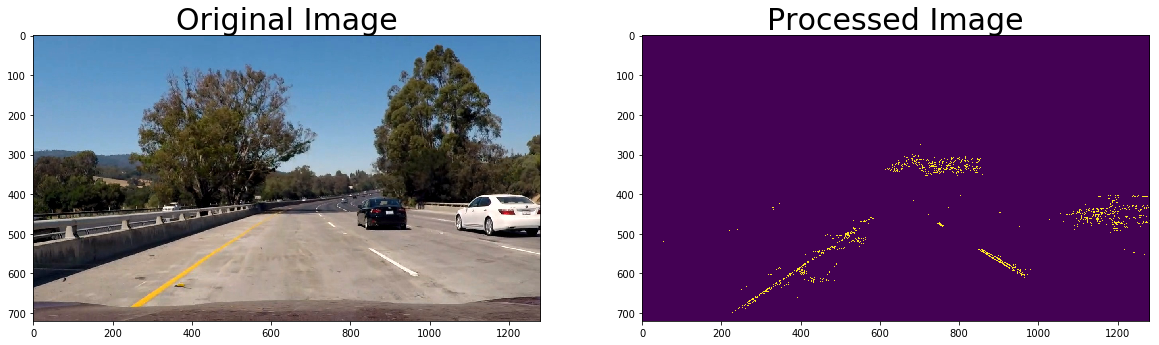

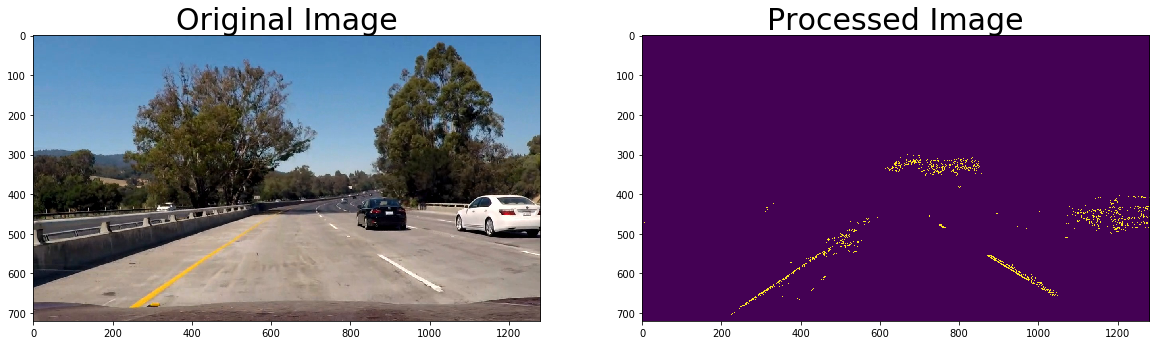

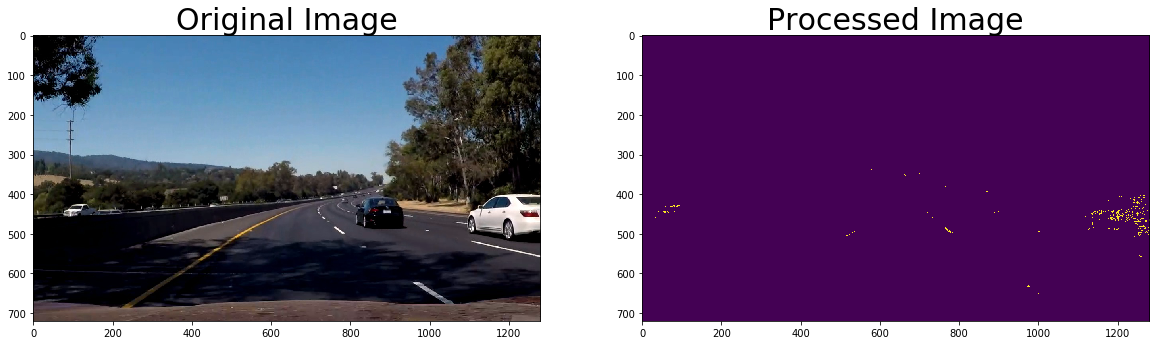

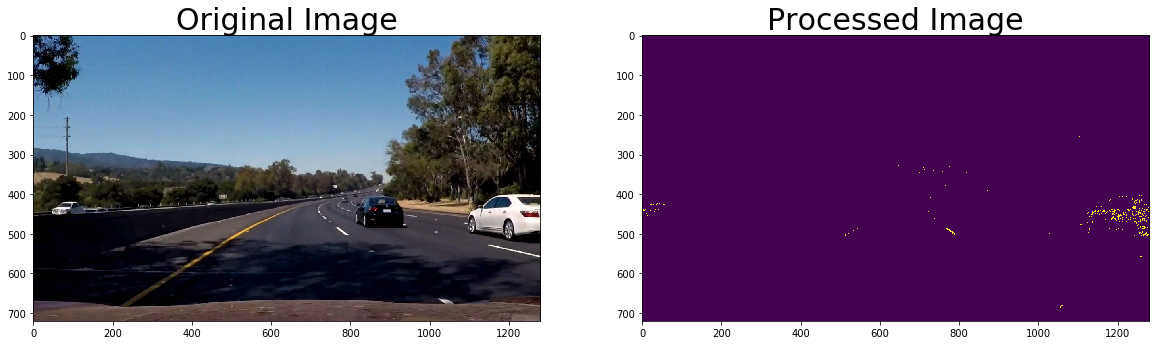

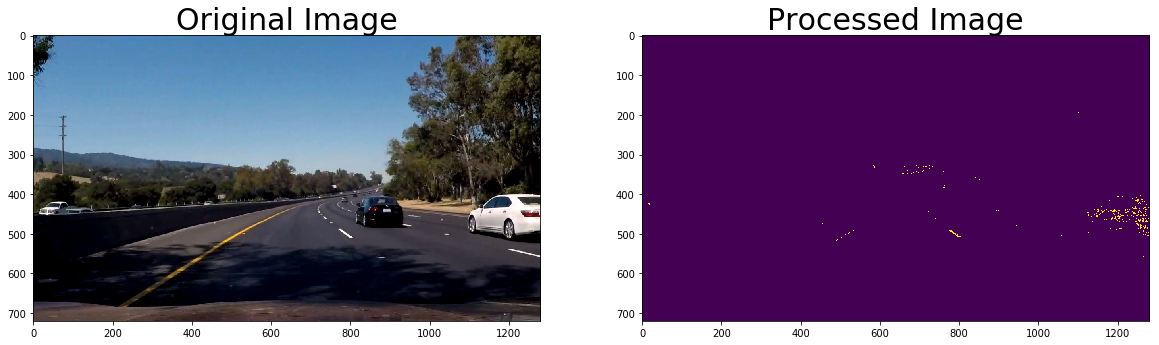

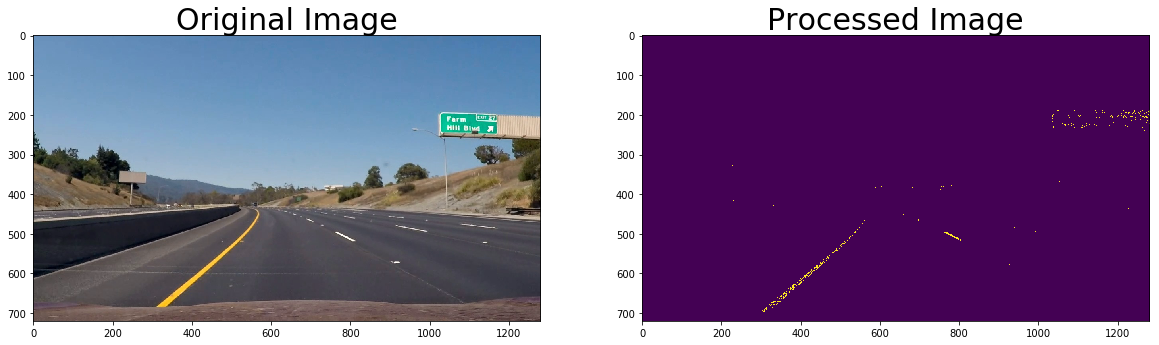

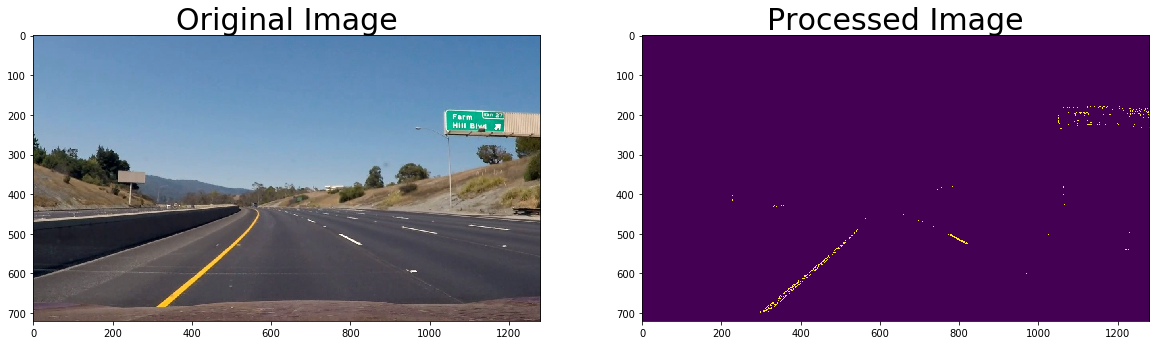

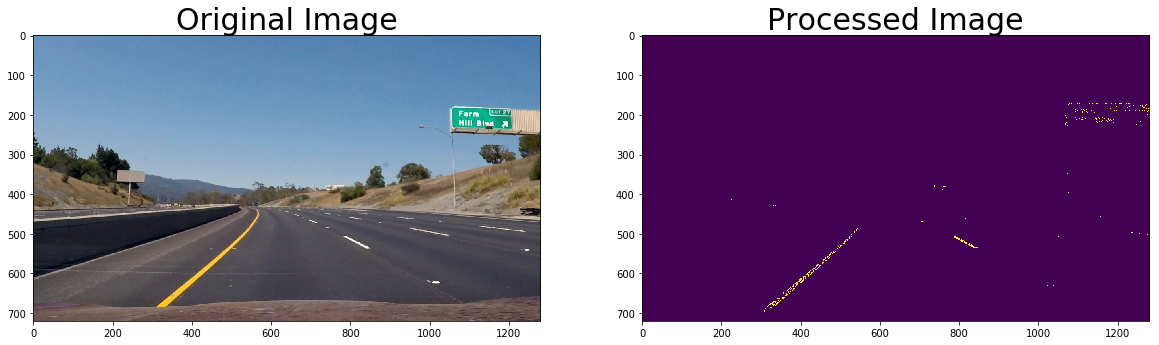

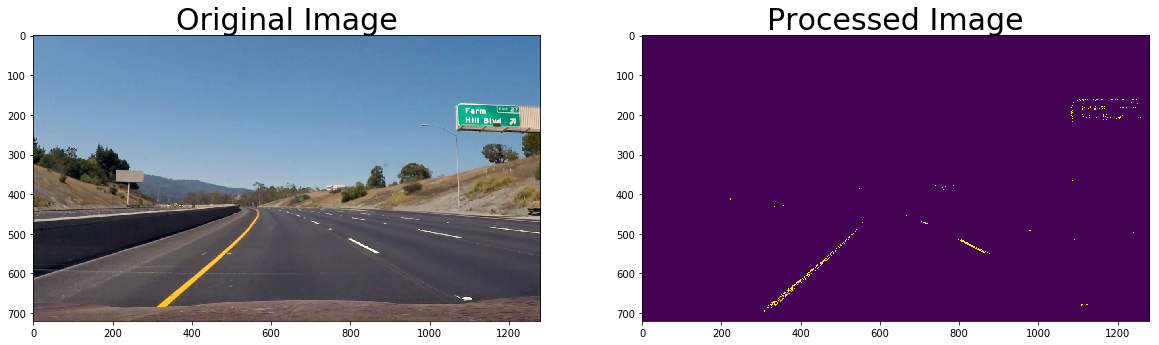

In [680]:
import matplotlib.pyplot as plt

for img in images:
    processed = process_image(img, mtx, dist)
    
    # Visualize                      
    %matplotlib inline
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(processed)
    ax2.set_title('Processed Image', fontsize=30)
    plt.show()

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [665]:
idx = 0
def process_image_short(img):
    global idx
    #cv2.imwrite('frames2/frame_{}.jpg'.format(idx), img)
    idx = idx + 1
    return process_image(img, mtx, dist)

In [670]:
output = 'project_video_processed.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,15)
clip1 = VideoFileClip("project_video.mp4") #.subclip(1,2)
white_clip = clip1.fl_image(process_image_short) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video_processed.mp4
[MoviePy] Writing video challenge_video_processed.mp4


100%|██████████| 485/485 [02:06<00:00,  4.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_processed.mp4 

CPU times: user 2min 23s, sys: 35.8 s, total: 2min 58s
Wall time: 2min 7s


In [710]:
img = cv2.imread('test_images/test2.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cv2.imwrite('pipeline/original.jpg', img)

undist = undistort_image(img, mtx, dist)

cv2.imwrite('pipeline/undistored.jpg', undist)

True

In [693]:
binary = process_image(undist, mtx, dist)
cv2.imwrite('pipeline/binary.jpg', np.uint8(binary*255))

True

In [702]:
img = cv2.imread('images/straight_lines.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = undistort_image(img, mtx, dist)
warped = camera_to_bird_eye_transform(undist)

In [707]:
print(warped[0])

[[[25 22 24]
  [25 21 23]
  [24 21 22]
  ..., 
  [79 76 89]
  [80 76 90]
  [80 76 90]]

 [[26 23 25]
  [26 23 24]
  [25 22 23]
  ..., 
  [79 76 89]
  [80 76 90]
  [80 76 90]]

 [[28 25 27]
  [28 25 26]
  [27 24 26]
  ..., 
  [79 76 89]
  [79 76 89]
  [80 76 90]]

 ..., 
 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ..., 
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ..., 
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ..., 
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]


In [704]:
cv2.imwrite('pipeline/aaa.jpg', warped)

TypeError: img is not a numerical tuple

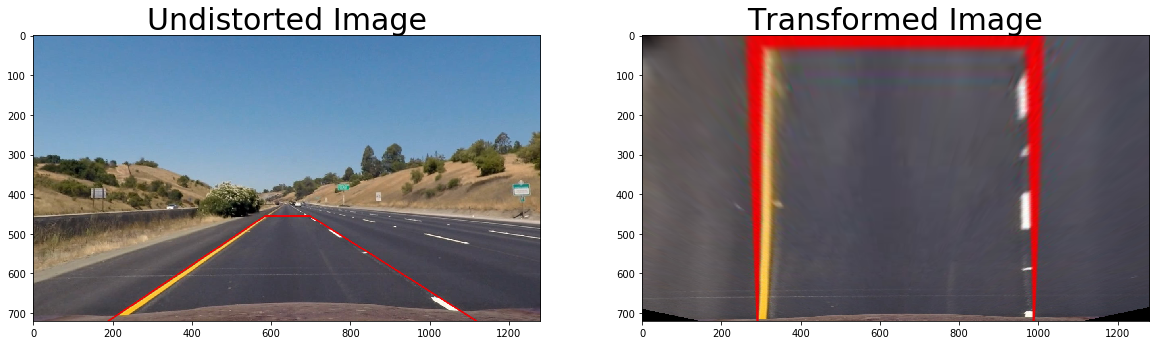

In [708]:
# Visualize undistortion
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warped[0])
ax2.set_title('Transformed Image', fontsize=30)

In [712]:
result = process_image_short(undist)

In [713]:
cv2.imwrite('pipeline/result.jpg', result)

True